In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from Games import *
import Utility
from os import listdir
from os.path import join
from json import load

In [3]:
def get_agent_playthroughs(config):
    playthroughs = []
    for filename in listdir(config.BASE_DIR):
        if filename.startswith('fitagent_playthrough_'):
            with open(join(config.BASE_DIR, filename), 'r') as f:
                data = load(f)
                playthroughs.append((filename, data))
            
    return playthroughs

In [4]:
def get_player_playthroughs(config, player_name):
    playthroughs = []
    starts_with_str = f'player_{player_name}_fit_playthrough_{config.NAME}'
    
    for filename in listdir(config.BASE_DIR):
        if filename.startswith(starts_with_str):
            with open(join(config.BASE_DIR, filename), 'r') as f:
                data = load(f)
                playthroughs.append((filename, data))
            
    return playthroughs

In [5]:
def heatmap(playthrough_data, graph, filename, bounds):
    max_x, max_y = bounds
    data = np.zeros((max_x + 1, max_y + 1))
    mask = np.ones((max_x + 1, max_y + 1))
    for n in graph.nodes:
        if '__' in n:
            continue
            
        a,b,_ = n.split(',')
        mask[int(a)][int(b)] = 0.0
    
    for run in playthrough_data:
        for segment, _, _, _ in run:
            if '__' in segment:
                continue
                
            a, b, _ = segment.split(',')
            data[int(a)][int(b)] += 1.0
    
    sns.set(rc = {'figure.figsize':(8,4)})
    ax = sns.heatmap(
        data, 
        mask=mask,
        square=True,
        cmap='Blues'
    )
#     ax = sns.heatmap(data, square=True)
    ax.invert_yaxis()
    ax.set_title(filename)
    ax.set_facecolor("gray")
    
    # reduce frequency for xticks
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 5 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    # reduce frequency for y ticks
    for ind, label in enumerate(ax.get_yticklabels()):
        if ind % 5 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.show()

In [6]:
def plot_reward_over_time(playthroughs):
    plot_data = {}
    for filename, data in playthroughs:
        legend_name = filename.split('.')[0].split('_')[-1]
        plot_data[legend_name] = []
        total_reward = 0
        
        for level in data:
            for _, _, _, r in level:
                total_reward += r
            
            plot_data[legend_name].append(total_reward)
    
    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.lineplot(data=plot_data)
    ax.set_title('Reward over Time')
        
    plt.show()

## Agent :: DungeonGrams

In [7]:
config = DungeonGrams
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config)

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_True.json


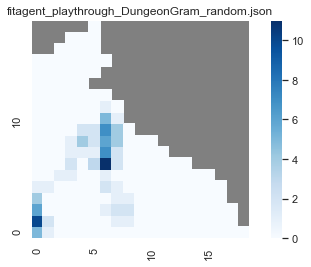

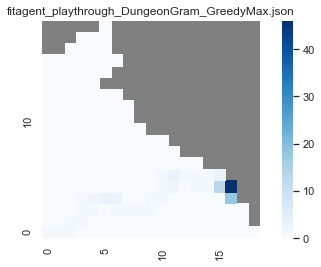

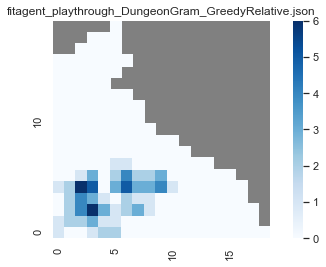

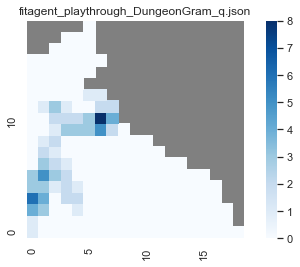

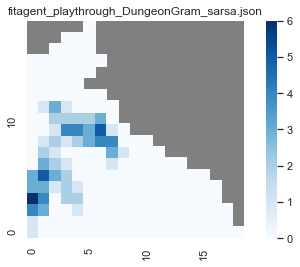

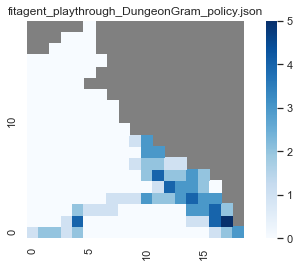

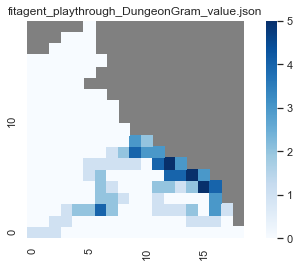

In [8]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

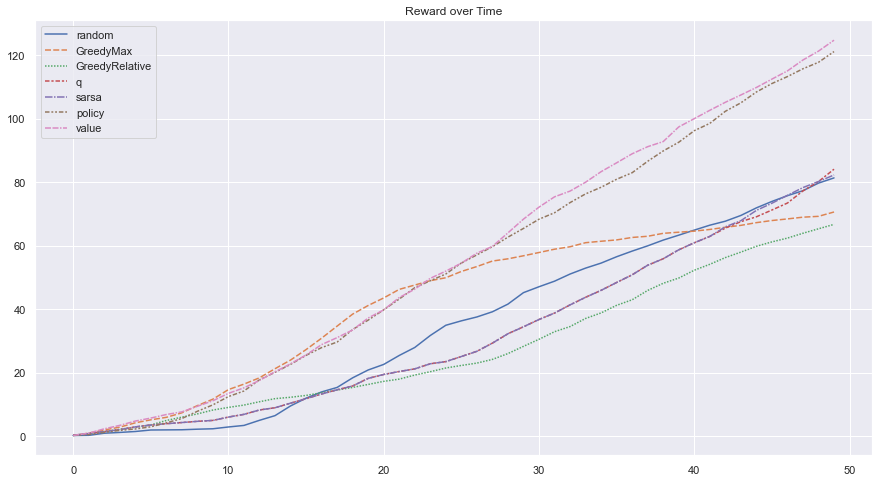

In [9]:
plot_reward_over_time(playthroughs)

## Agent :: Mario

In [10]:
config = Mario
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config)

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


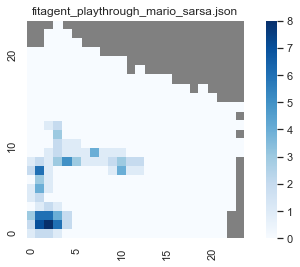

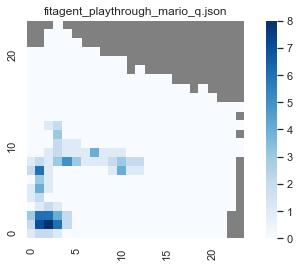

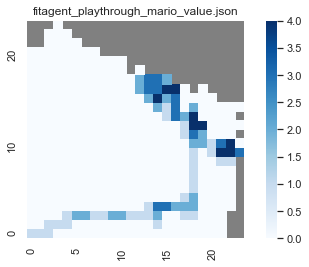

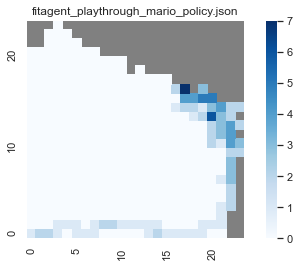

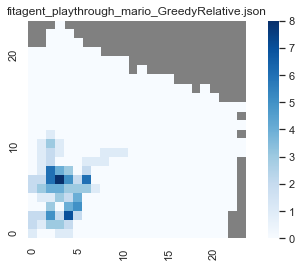

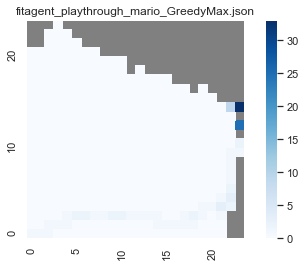

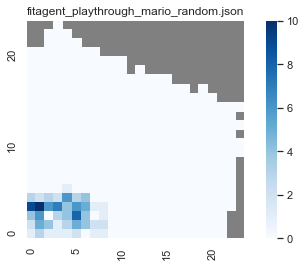

In [11]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

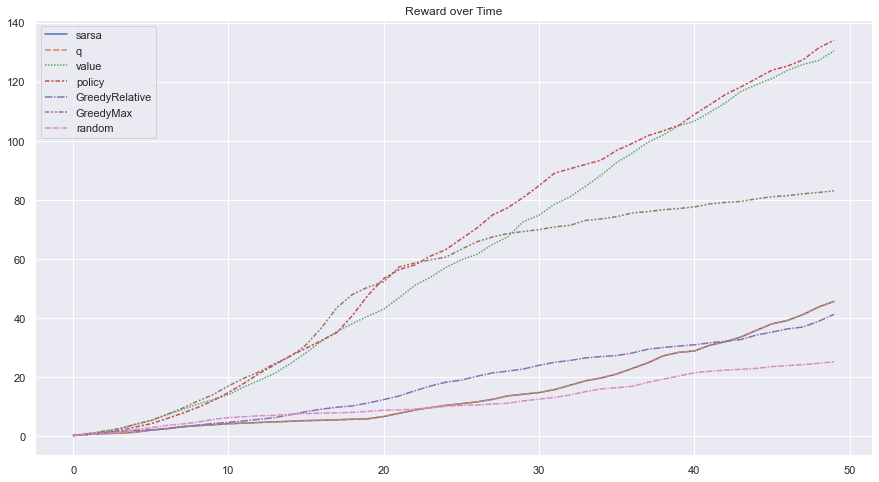

In [12]:
plot_reward_over_time(playthroughs)

## Agent ::  Icarus

In [13]:
config = Icarus
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config)

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


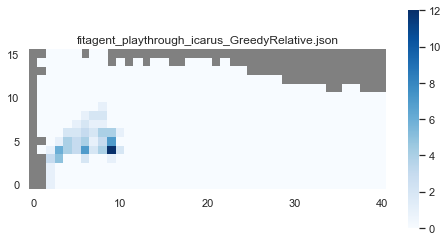

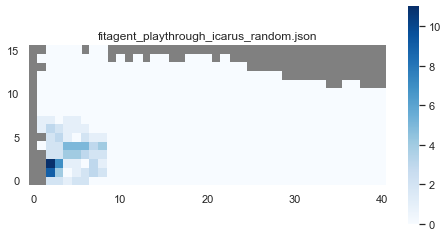

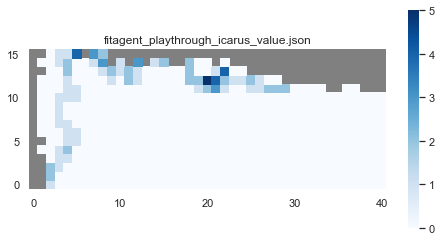

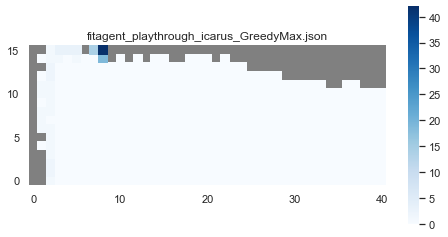

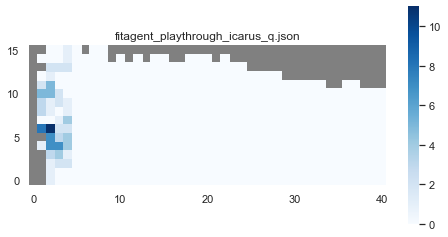

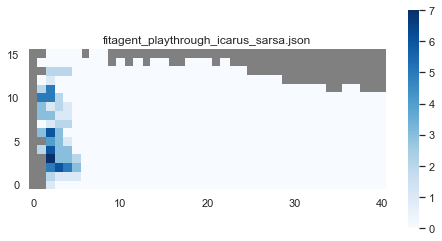

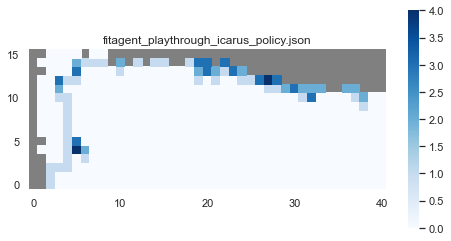

In [14]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

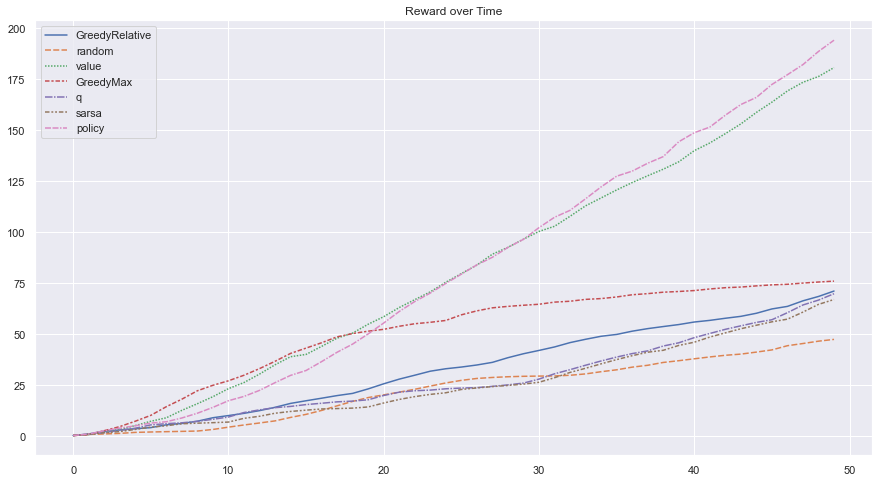

In [15]:
plot_reward_over_time(playthroughs)

# Player Personas

In [16]:
def get_df(playthroughs):
    data = []
    labels = ['Director', 'Player', 'Percent Complete', 'Player Reward', 'Total Reward']
    for name, run_data in playthroughs:
        director_name = name.split('.')[0].split('_')[-1]
        player_name = name.split('_')[1]

        for run in run_data:
            run_percent_complete = 0
            run_player_reward = 0
            run_total_reward = 0

            for lvl in run:
                for _, percent_complete, player_reward, total_reward in lvl:
                    run_percent_complete += percent_complete
                    run_player_reward += player_reward
                    run_total_reward += total_reward

            data.append((
                director_name, 
                player_name, 
                run_percent_complete, 
                run_player_reward, 
                run_total_reward))

    return pd.DataFrame(data, columns=labels)\
        .groupby(['Director', 'Player']).agg(['mean', 'std']) \
        .sort_values(by=('Total Reward', 'mean'), ascending=False)

# Player Personas :: Mario

In [17]:
config = Mario
graph = Utility.get_graph(config, True)
playthroughs = get_player_playthroughs(config, 'Bad Player Likes Hard Levels')
df = get_df(playthroughs)
mario_player_persona_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


Percent Complete             \
                                                        mean        std   
Director       Player                                                     
policy         Bad Player Likes Hard Levels        80.321192   8.140709   
value          Bad Player Likes Hard Levels        72.998912   5.896122   
GreedyMax      Bad Player Likes Hard Levels        63.316387   6.529140   
GreedyRelative Bad Player Likes Hard Levels       140.895966  20.973575   
sarsa          Bad Player Likes Hard Levels       150.499133   8.272906   
q              Bad Player Likes Hard Levels       153.215412  12.699391   
random         Bad Player Likes Hard Levels       156.312257  19.424290   

                                            Player Reward             \
                                                     mean        std   
Director       Player                                                  
policy         Bad Player Likes Hard Levels     55.571087   2.542585   
value          Bad Player Likes Hard Levels     55.088696   3.659856   
GreedyMax      Bad Player Likes Hard Levels     52.806739   2.465542   
GreedyRelative Bad Player Likes Hard Levels     18.463696  16.152626   
sarsa          Bad Player Likes Hard Levels     13.833913   7.886919   
q              Bad Player Likes Hard Levels      9.072609   8.466360   
random         Bad Player Likes Hard Levels      8.422391  14.249234   

                                            Total Reward             
                                                    mean        std  
Director       Player                                                
policy         Bad Player Likes Hard Levels   100.620741   6.102004  
value          Bad Player Likes Hard Levels    97.174324   9.074680  
GreedyMax      Bad Player Likes Hard Levels    85.291876   7.739210  
GreedyRelative Bad Player Likes Hard Levels    62.142636  23.618708  
sarsa          Bad Player Likes Hard Levels    60.846738  16.093815  
q              Bad Player Likes Hard Levels    49.546911  16.292293  
random         Bad Player Likes Hard Levels    42.389605  29.531399

# Player Personas :: Icarus

In [18]:
config = Icarus
graph = Utility.get_graph(config, True)
playthroughs = get_player_playthroughs(config, 'Bad Player Likes Hard Levels')
df = get_df(playthroughs)
icarus_player_persona_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


Percent Complete             \
                                                        mean        std   
Director       Player                                                     
value          Bad Player Likes Hard Levels        83.612815   4.045381   
policy         Bad Player Likes Hard Levels        84.621882   5.777754   
GreedyMax      Bad Player Likes Hard Levels        76.011759   6.080155   
GreedyRelative Bad Player Likes Hard Levels       179.280518  18.868138   
q              Bad Player Likes Hard Levels       175.470122  19.046642   
sarsa          Bad Player Likes Hard Levels       177.352624  23.979385   
random         Bad Player Likes Hard Levels       179.414591   8.553821   

                                            Player Reward             \
                                                     mean        std   
Director       Player                                                  
value          Bad Player Likes Hard Levels     60.806875   3.167079   
policy         Bad Player Likes Hard Levels     60.403333   4.275883   
GreedyMax      Bad Player Likes Hard Levels     60.036042   2.371746   
GreedyRelative Bad Player Likes Hard Levels     15.240833  12.185061   
q              Bad Player Likes Hard Levels     14.693333   8.581883   
sarsa          Bad Player Likes Hard Levels     12.565833  11.770617   
random         Bad Player Likes Hard Levels      6.554375   5.971308   

                                            Total Reward             
                                                    mean        std  
Director       Player                                                
value          Bad Player Likes Hard Levels   114.334325   6.375593  
policy         Bad Player Likes Hard Levels   113.762395   9.158872  
GreedyMax      Bad Player Likes Hard Levels    94.109060   5.362189  
GreedyRelative Bad Player Likes Hard Levels    80.469947  19.917965  
q              Bad Player Likes Hard Levels    75.252248  18.445021  
sarsa          Bad Player Likes Hard Levels    71.171043  15.910843  
random         Bad Player Likes Hard Levels    56.936929  18.115595

# Player Personas :: DungeonGrams

In [19]:
config = DungeonGrams
graph = Utility.get_graph(config, True)
playthroughs = get_player_playthroughs(config, 'Bad Player Likes Hard Levels')
df = get_df(playthroughs)
dg_player_persona_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_True.json


Percent Complete             \
                                                        mean        std   
Director       Player                                                     
value          Bad Player Likes Hard Levels        95.204587   7.493724   
policy         Bad Player Likes Hard Levels        91.643105   7.693874   
GreedyMax      Bad Player Likes Hard Levels        86.711068   6.588576   
sarsa          Bad Player Likes Hard Levels       161.496204  21.037856   
q              Bad Player Likes Hard Levels       173.694503  25.384589   
GreedyRelative Bad Player Likes Hard Levels       174.542815  33.346399   
random         Bad Player Likes Hard Levels       184.770586  20.016692   

                                            Player Reward             \
                                                     mean        std   
Director       Player                                                  
value          Bad Player Likes Hard Levels     56.010000   2.262765   
policy         Bad Player Likes Hard Levels     55.480833   4.773609   
GreedyMax      Bad Player Likes Hard Levels     56.226389   5.354317   
sarsa          Bad Player Likes Hard Levels     25.578889   9.024072   
q              Bad Player Likes Hard Levels     19.578611  14.176113   
GreedyRelative Bad Player Likes Hard Levels     17.568056  17.995162   
random         Bad Player Likes Hard Levels     13.281944  13.541575   

                                            Total Reward             
                                                    mean        std  
Director       Player                                                
value          Bad Player Likes Hard Levels   109.285509   3.959718  
policy         Bad Player Likes Hard Levels   103.999952   9.937670  
GreedyMax      Bad Player Likes Hard Levels    90.548854   6.072493  
sarsa          Bad Player Likes Hard Levels    84.780942  13.840537  
q              Bad Player Likes Hard Levels    79.961572  18.984155  
GreedyRelative Bad Player Likes Hard Levels    69.598212  24.199018  
random         Bad Player Likes Hard Levels    63.057626  30.108167